# Packages and Configurations

In [1]:
import astro_util, os
import numpy as np
import pandas as pd
import astroalign as aa
import statsmodels.api as sm
from astropy.io import fits
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, PRFAdapter, IntegratedGaussianPRF
from matplotlib import pyplot as plt
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath, physics}")
plt.rc("font", family="serif", serif=["Computer Modern"])
plt.rc("axes", titlesize=20, labelsize=18)
plt.rc("figure", titlesize=20)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=10)

# Alignment and Photometry

In [11]:
hip_magnitude, persei_magnitude, hip_error, persei_error = [], [], [], []
persei_roundness1, hip_roundness1 = [], []
persei_roundness2, hip_roundness2 = [], []
psf_model = IntegratedGaussianPRF(
    fixed={'flux':False, 'x_0':False, 'y_0':False, 'sigma':False})

reference_data = astro_util.srgb_to_grayscale(
    fits.open("./data/stars/"
    + os.listdir("./data/stars/")[0])[0].data)

for filename in os.listdir("./data/stars/"):
    data = fits.open("./data/stars/" + filename)[0].data
    data = astro_util.srgb_to_grayscale(data)

    median = np.median(data)
    std = np.std(data)
    daofind = DAOStarFinder(fwhm=3.0, threshold=3*std+median)
    stars = daofind(data)

    # psfphot = PSFPhotometry(psf_model, (7, 7), finder=daofind,
    #                         aperture_radius=4)
    # photometry = psfphot(data - np.median(data))

    transformation, _ = aa.find_transform(reference_data, data)
    xypersei, xyhip = aa.matrix_transform(
        np.array([[2852.41, 1594.9], [2238.83, 1645.89]]),
        transformation.params)

    # xs, ys = np.array(photometry["x_fit"]), np.array(photometry["y_fit"])
    xs, ys = np.array(stars["xcentroid"]), np.array(stars["ycentroid"])
    persei_idx = np.argmin((xs - xypersei[0])**2 + (ys - xypersei[1])**2)
    hip_idx = np.argmin((xs - xyhip[0])**2 + (ys - xyhip[1])**2)

    persei_roundness1.append(stars["roundness1"][persei_idx])
    persei_roundness2.append(stars["roundness2"][persei_idx])
    hip_roundness1.append(stars["roundness1"][hip_idx])
    hip_roundness2.append(stars["roundness2"][hip_idx])

    persei_photometry = astro_util.aperture_photometry(
        data, (xs[persei_idx], ys[persei_idx]))
    hip_photometry = astro_util.aperture_photometry(
        data, (xs[hip_idx], ys[hip_idx]))

    persei_magnitude.append(persei_photometry["magnitude"])
    hip_magnitude.append(hip_photometry["magnitude"])
    persei_error.append(persei_photometry["error"])
    hip_error.append(hip_photometry["error"])

    # persei_mag = -2.5 * np.log10(photometry["flux_fit"][persei_idx])
    # hip_mag = -2.5 * np.log10(photometry["flux_fit"][hip_idx])
    # persei_err = 1.08 * (photometry["flux_err"][persei_idx]
    #                      / photometry["flux_fit"][persei_idx])
    # hip_err = 1.08 * (photometry["flux_err"][hip_idx]
    #                   / photometry["flux_fit"][hip_idx])

    # persei_magnitude.append(persei_mag)
    # hip_magnitude.append(hip_mag)
    # persei_error.append(persei_err)
    # hip_error.append(hip_err)

In [12]:
data = fits.open("./data/stars/" + os.listdir("./data/stars/")[13])[0].data
data = astro_util.srgb_to_grayscale(data)
hip_photometry = astro_util.aperture_photometry(data, (1897.49, 1692.39))
hip_magnitude[13] = hip_photometry["magnitude"]
hip_error[13] = hip_photometry["error"]

In [22]:
df = pd.read_csv("./data/unprocessed/coordinates.csv")
pd.DataFrame({"z" : 1 / np.cos(np.pi / 180 * df["FZ Persei"]),
              "mag" : persei_magnitude, "error" : persei_error,
              "roundness1" : persei_roundness1, "roundness2" : persei_roundness2}
             ).to_csv("./data/persei.csv", index=False)
pd.DataFrame({"z" : 1 / np.cos(np.pi / 180 * df["HIP 11020"]), "mag" : hip_magnitude,
              "error" : hip_error, "roundness1" : hip_roundness1,
              "roundness2" : hip_roundness2}).to_csv("./data/hip.csv", index=False)

# Analysis

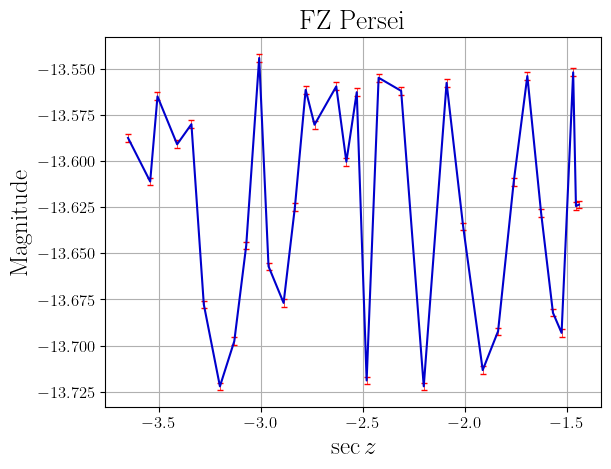

In [14]:
df = pd.read_csv("./data/persei.csv")
plt.errorbar(1 / np.cos(df["z"]), df["mag"], df["error"],
             color="mediumblue", ecolor="red", capsize=2, elinewidth=0.5)
plt.title("FZ Persei")
plt.ylabel("Magnitude")
plt.xlabel(r"$\sec z$")
plt.grid()
plt.savefig("fig/persei.pdf")
plt.show()

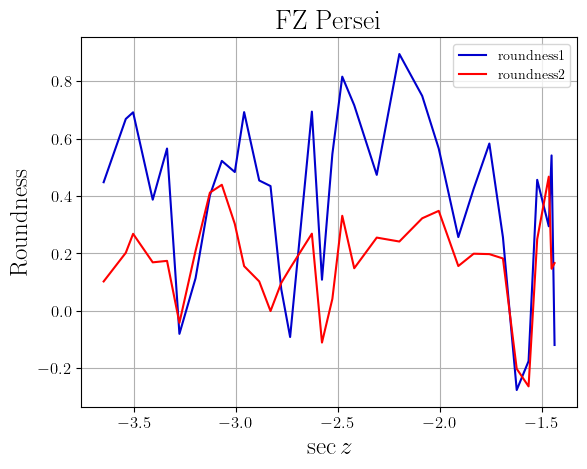

In [24]:
df = pd.read_csv("./data/persei.csv")
plt.plot(1 / np.cos(df["z"]), df["roundness1"],
         color="mediumblue", label="roundness1")
plt.plot(1 / np.cos(df["z"]), df["roundness2"],
         color="red", label="roundness2")
plt.title("FZ Persei")
plt.ylabel("Roundness")
plt.xlabel(r"$\sec z$")
plt.grid()
plt.legend()
plt.savefig("fig/roundness.pdf")
plt.show()

In [15]:
airmass = 1 / np.cos(df["z"][df["mag"] > -13.6])
mag = df["mag"][df["mag"] > -13.6]

In [16]:
fit = sm.OLS(mag, sm.add_constant(airmass)).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    mag   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     9.058
Date:                Mon, 04 Sep 2023   Prob (F-statistic):             0.0109
Time:                        10:22:12   Log-Likelihood:                 44.280
No. Observations:                  14   AIC:                            -84.56
Df Residuals:                      12   BIC:                            -83.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.5279      0.013  -1061.782      0.0

c:\Users\SLHHe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [17]:
confidence = fit.conf_int(0.05)
print((confidence[1]['z'] - confidence[0]['z']) / 2)

0.010061713684367157


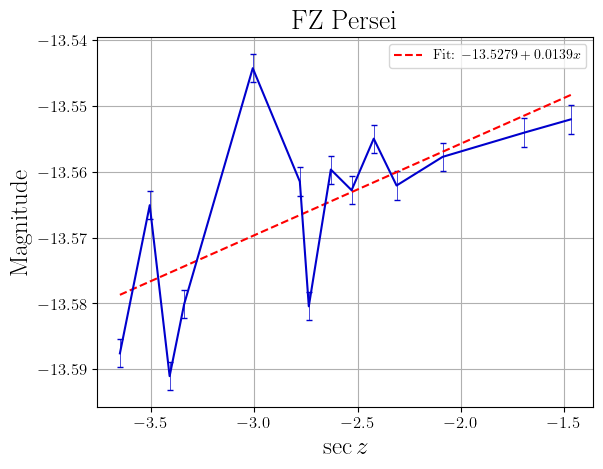

In [21]:
df = pd.read_csv("./data/persei.csv")
plt.errorbar(airmass, mag, df["error"][df["mag"] > -13.6],
             color="mediumblue", capsize=2, elinewidth=0.5)
plt.plot(airmass, fit.fittedvalues, "r--",
         label=fr"Fit: ${fit.params[0]:.4f} + {fit.params[1]:.4f}x$")
plt.title("FZ Persei")
plt.ylabel("Magnitude")
plt.xlabel(r"$\sec z$")
plt.grid()
plt.legend()
plt.savefig("fig/fit.pdf")
plt.show()

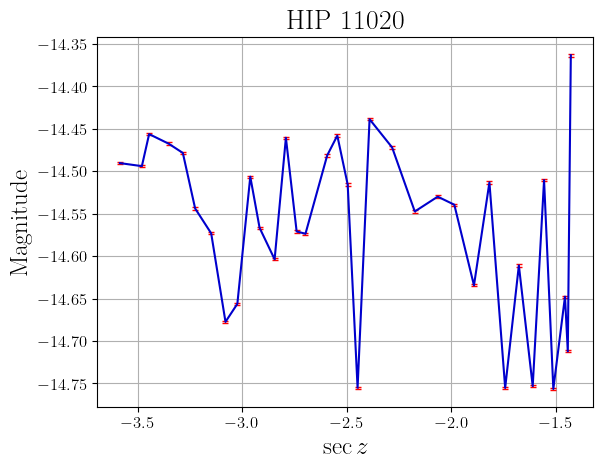

In [25]:
df = pd.read_csv("./data/hip.csv")
plt.errorbar(1 / np.cos(df["z"]), df["mag"], df["error"],
             color="mediumblue", ecolor="red", capsize=2, elinewidth=0.5)
plt.title("HIP 11020")
plt.ylabel("Magnitude")
plt.xlabel(r"$\sec z$")
plt.grid()
plt.savefig("fig/hip.pdf")
plt.show()

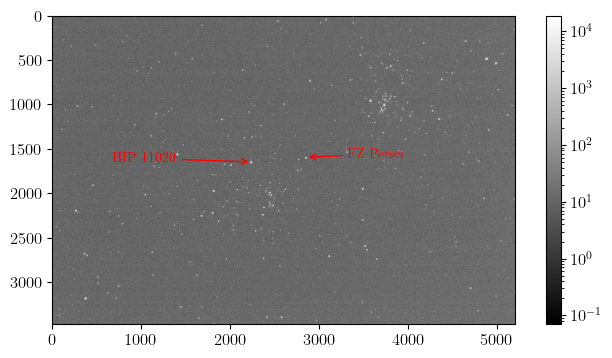

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(reference_data, cmap="gray", norm="log")
fig.colorbar(im)

ax.annotate("FZ Persei", (2852.41, 1594.9),
            (30, 0), textcoords="offset points", color="red",
            arrowprops=dict(arrowstyle="->", color="red"))
ax.annotate("HIP 11020", (2238.83, 1645.89),
            (-100, 0), textcoords="offset points", color="red",
            arrowprops=dict(arrowstyle="->", color="red"))

plt.savefig("fig/stars.pdf", bbox_inches="tight", dpi=300)
plt.show()